In [3]:
from src.har.har_backend import compilers, pd
from src.tsshapelet.shapelet import Shapelet
from src.tsclustering.kmeans import KMeans
import matplotlib.pyplot as plt; plt.rcParams["figure.figsize"] = (30,15)


## <center> Motivation</center>

### <center>Accelerometer Activity Data</center>

##### Accelerometer activity data is a time series signal, representing the magnitude of acceleration, on three axes, over time. Here we have combined all three axes, x, y,z, into one, the vector magnitude.

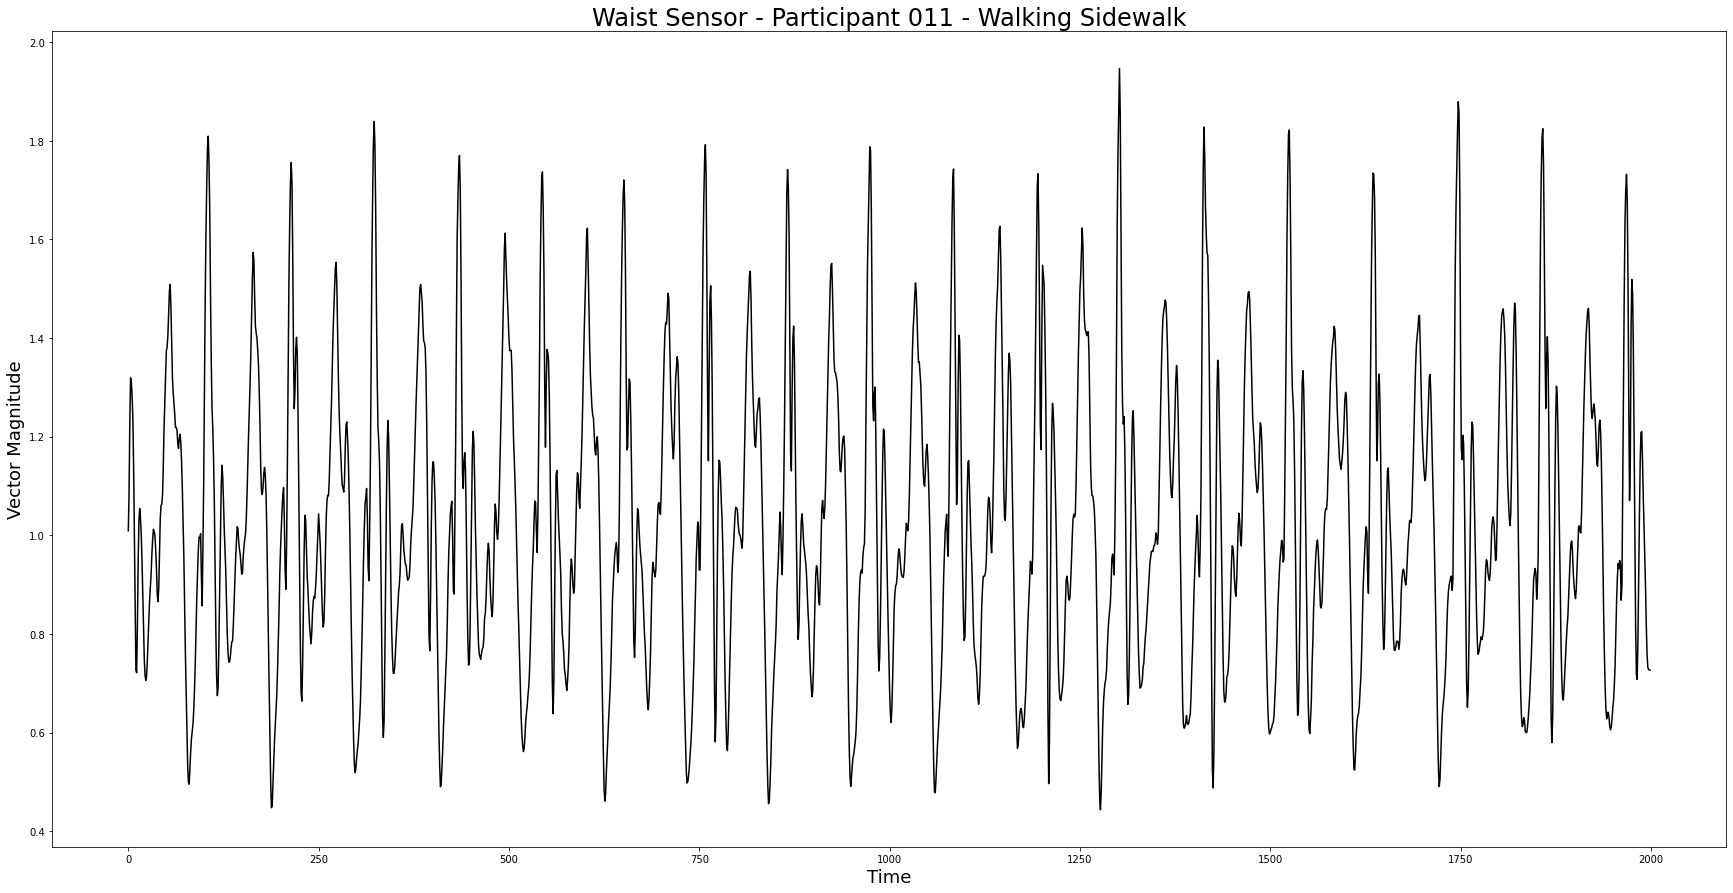

In [4]:
df = pd.read_csv('../data/labeled_activity_data/011_labeled.csv')
shape = Shapelet(df[df.activity == 'walk_sidewalk']['waist_vm'][500:2500])
plt.plot(shape.series, color = 'black');
plt.title('Waist Sensor - Participant 011 - Walking Sidewalk', fontsize = 24);
plt.xlabel('Time', fontsize = 18);
plt.ylabel('Vector Magnitude', fontsize = 18);

### <center>Gait Cycle Extraction</center>

##### <center>Here we run an algorithm to detect each time you take a step.</center>

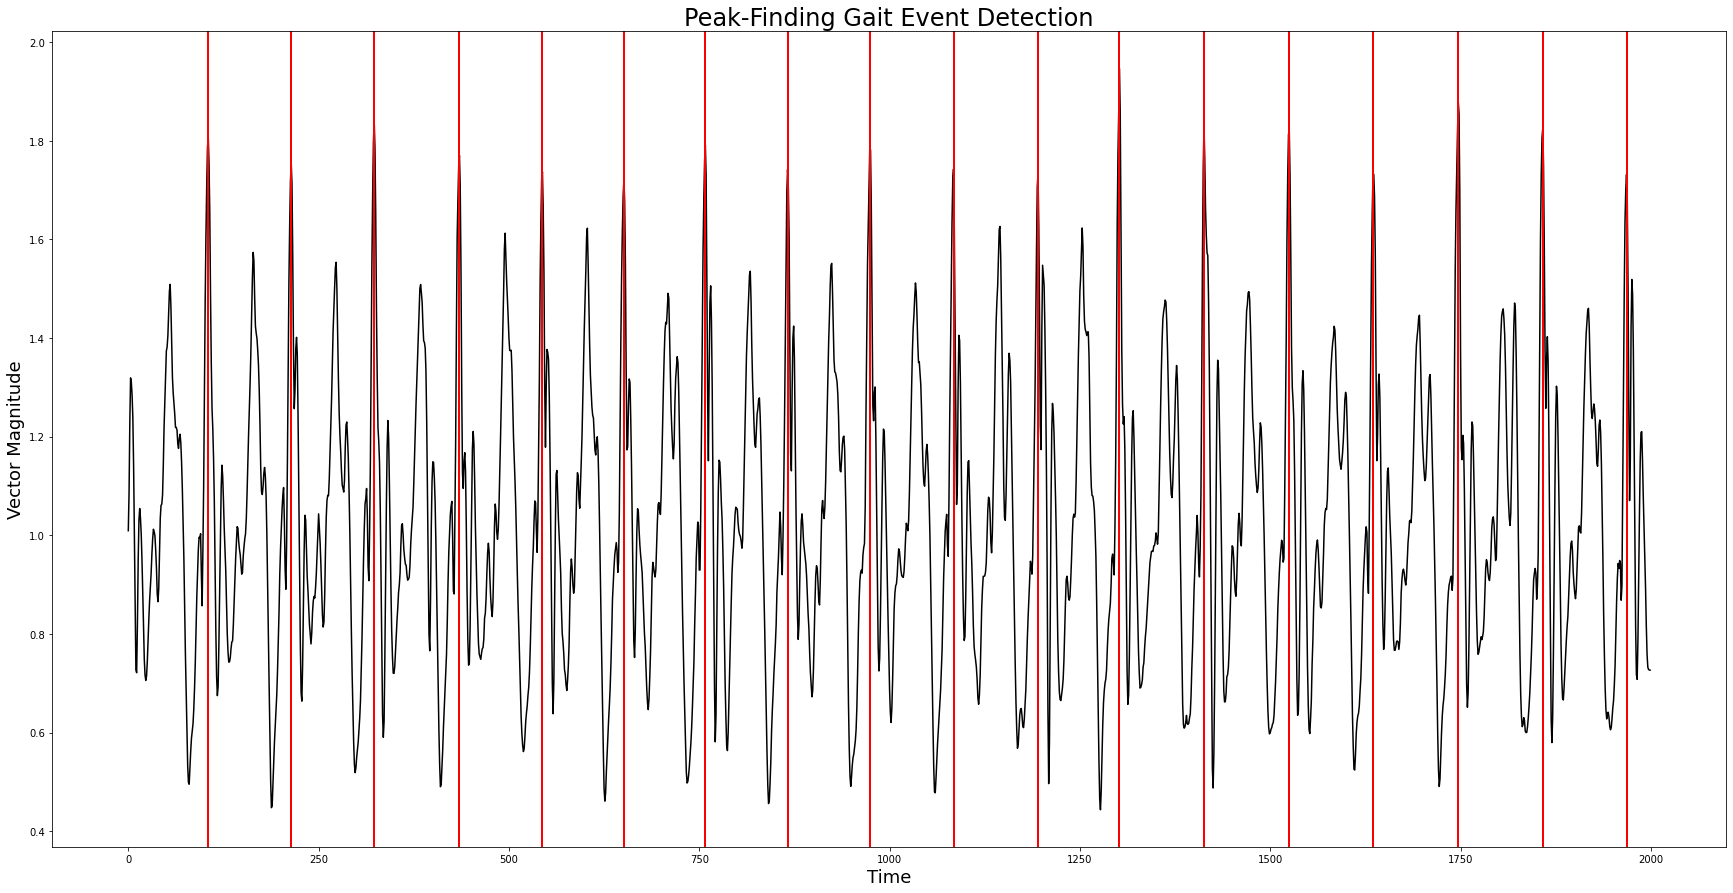

In [5]:
shape.peak_extraction(min_dist = 60, max_dist = 150, thres = 0.9)
plt.plot(shape.series,color = 'black');
for ind in shape.indices:
    plt.axvline(x=ind, color = 'red', lw = 2)
plt.title('Peak-Finding Gait Event Detection', fontsize = 24);
plt.xlabel('Time', fontsize = 18);
plt.ylabel('Vector Magnitude', fontsize = 18);

### <center>Gait Averaging</center>

##### <center> We compile each extracted gait, and create an "average gait pattern"</center>

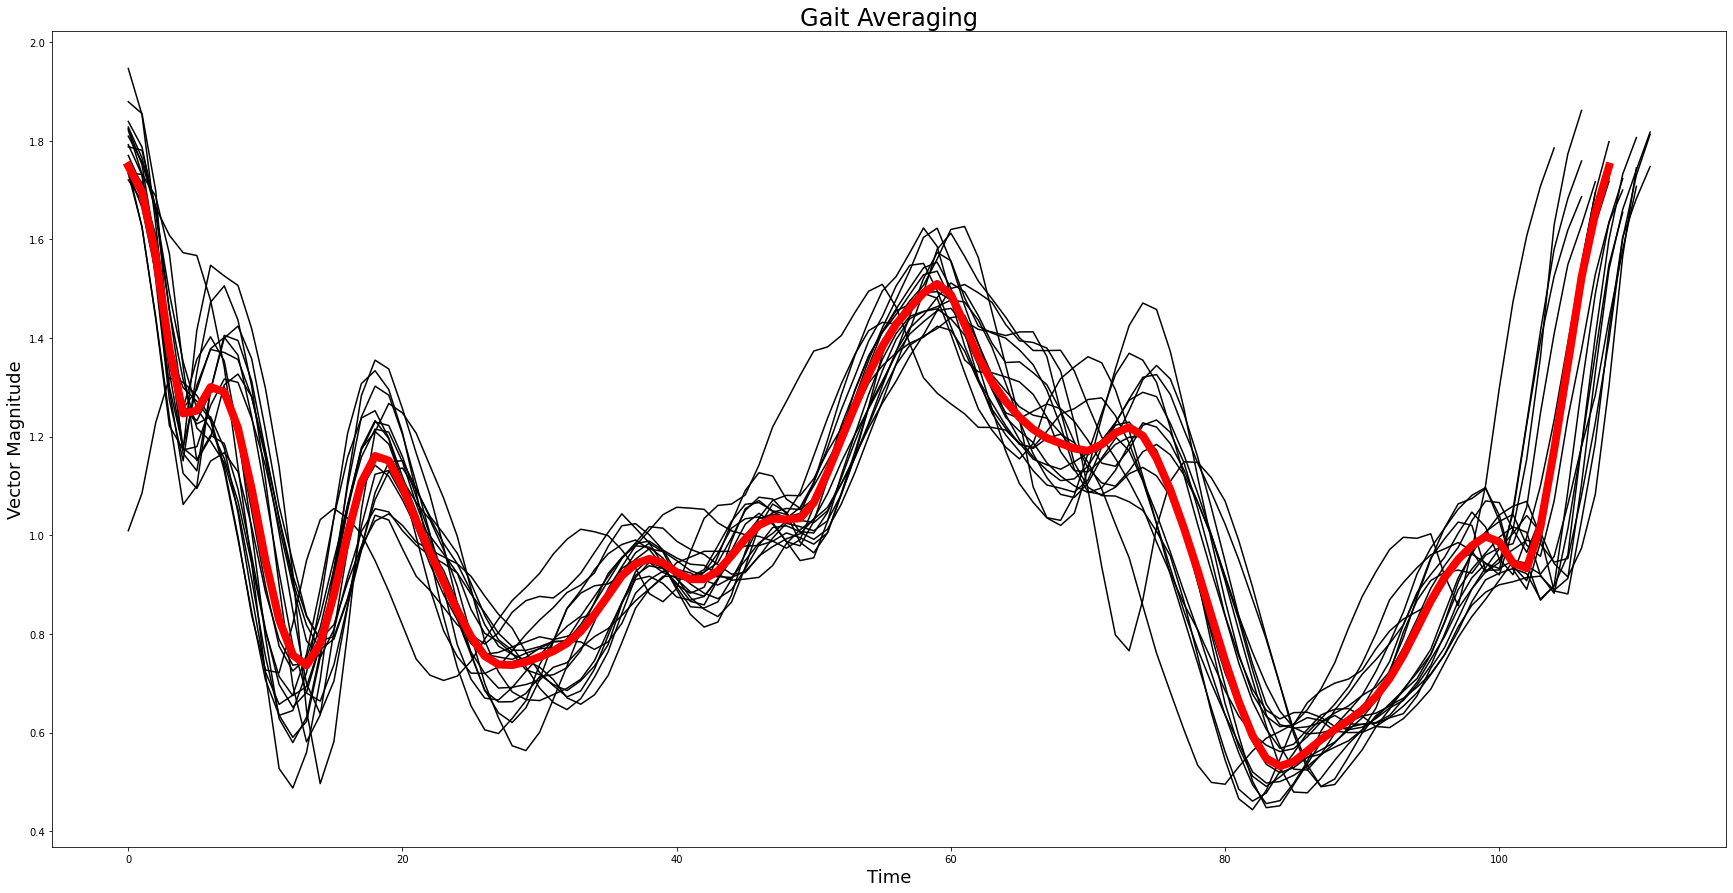

In [6]:
shape.shapelet_selection(barycenter = 'interpolated')
for candidate in shape.candidates:
    plt.plot(candidate, color = 'black');
plt.plot(shape.shapelets[0], color = 'red', lw = 8);
plt.title('Gait Averaging', fontsize = 24);
plt.xlabel('Time', fontsize = 18);
plt.ylabel('Vector Magnitude', fontsize = 18);

### <center> Gait Clustering</center>

##### <center>These gait patterns are unique to each individual. We can exploit the differences in gait patterns to cluster individuals into categories. </center>

In [43]:
''' Hyperparameters '''
# Data Aggregation
sensor = 'waist'
axis = 'vm'
activity = 'walk_treadmill'
sample = 100

''' Aggregating Data '''
data = compilers['aggregate'](directory = '../data/labeled_activity_data/')
df = data[(data.activity == activity)][[sensor+'_'+axis, 'person', 'activity']]

# Shapelet Creation
shapelet_size = 400
smoothing_period = 1
thres = 0.7
min_dist = 80
max_dist = 180
extraction = 'peak'
barycenter = 'interpolated'
metric = 'dtw'
comparison = 'candidates'

''' Extracting Shapelets '''
shapelets = {}
for person in sorted(df.person.unique()):
    shape = Shapelet(df[df.person == person]['waist_vm'].reset_index(drop=True))
    shape.smooth(smoothing_period)
    shape.candidate_extraction(extraction = extraction, min_dist = min_dist, thres = thres, max_dist = max_dist, sample = sample)
    shape.shapelet_selection(barycenter = barycenter, qty = 1, comparison = comparison)
    shapelets[person] = shape.shapelets[0]

''' Clustering '''
X = [shapelets[person] for person in shapelets]
gkm = KMeans(k_clusters = 6,  n_init = 5, max_iter = 100, metric = 'dtw', averaging = 'interpolated')
gkm.fit(X)

##### Clusters can be used to do other analysis, such as gait pathology, biometrics comparisons, and post-operation patient recovery 

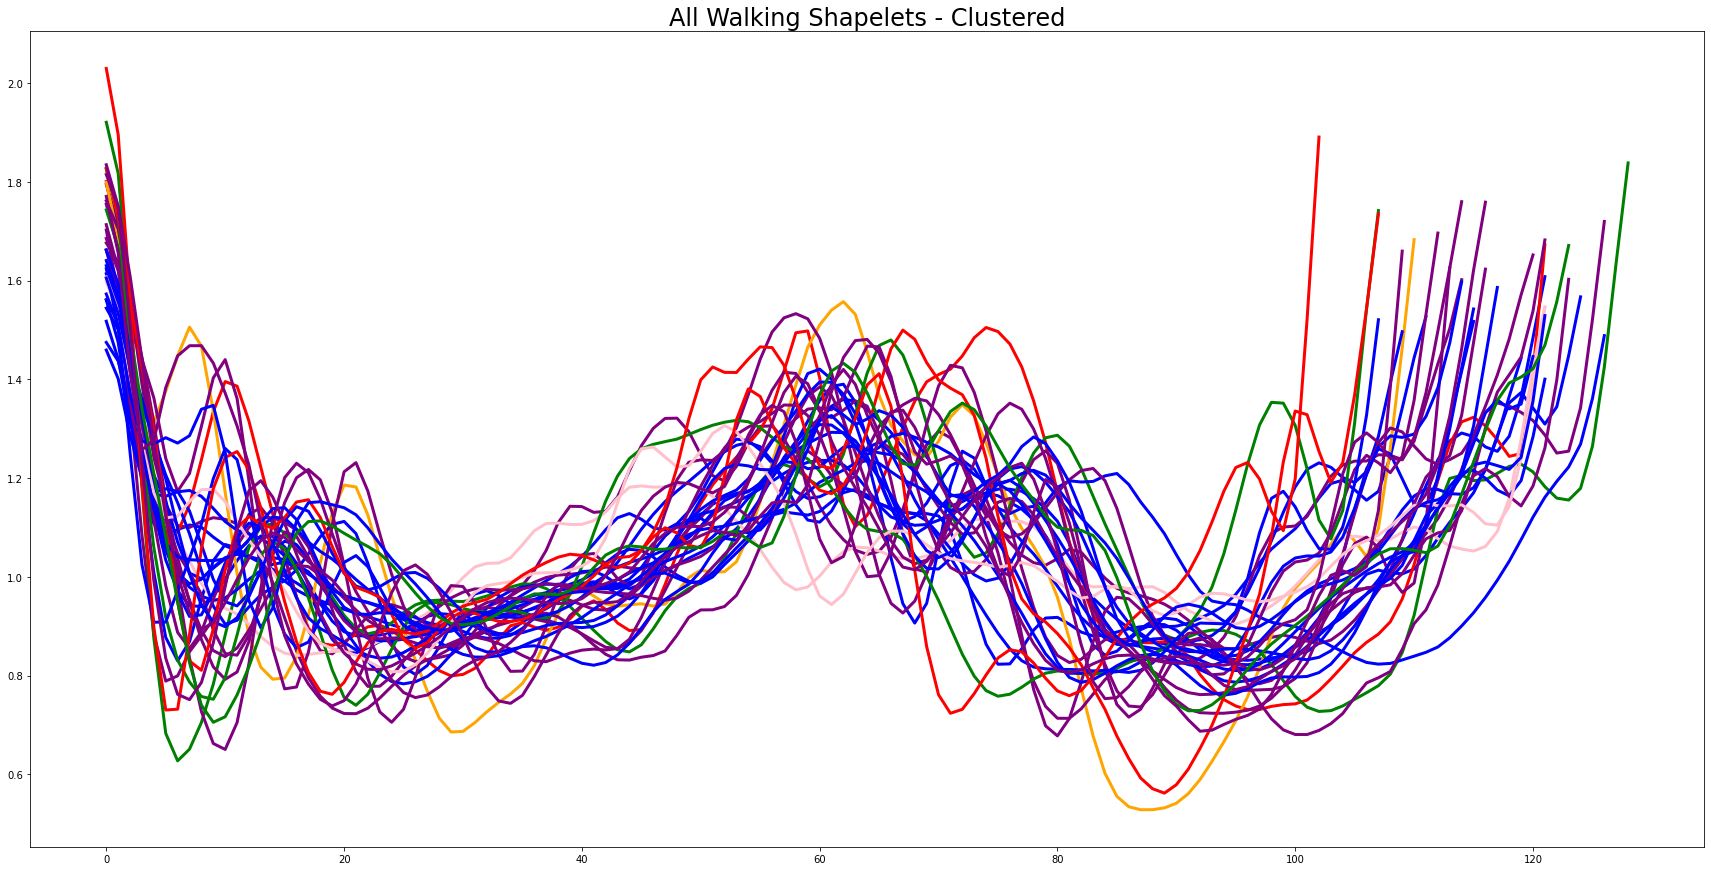

In [54]:
colors = ['red', 'green', 'blue', 'orange', 'purple', 'pink']*2
for i, shape in enumerate(gkm.X):
    plt.plot(shape, color = colors[gkm.clusters[i]], lw = 3);
plt.title('All Walking Shapelets - Clustered', fontsize = 24);

### <center>Classification</center>

##### <center>These gait patterns may also be used to classify incoming signals from wearable devices to determine what activity the user is doing. Here we show the distinct patterns between the same individual walking on the sidewalk and walking on the treadmill.</center>

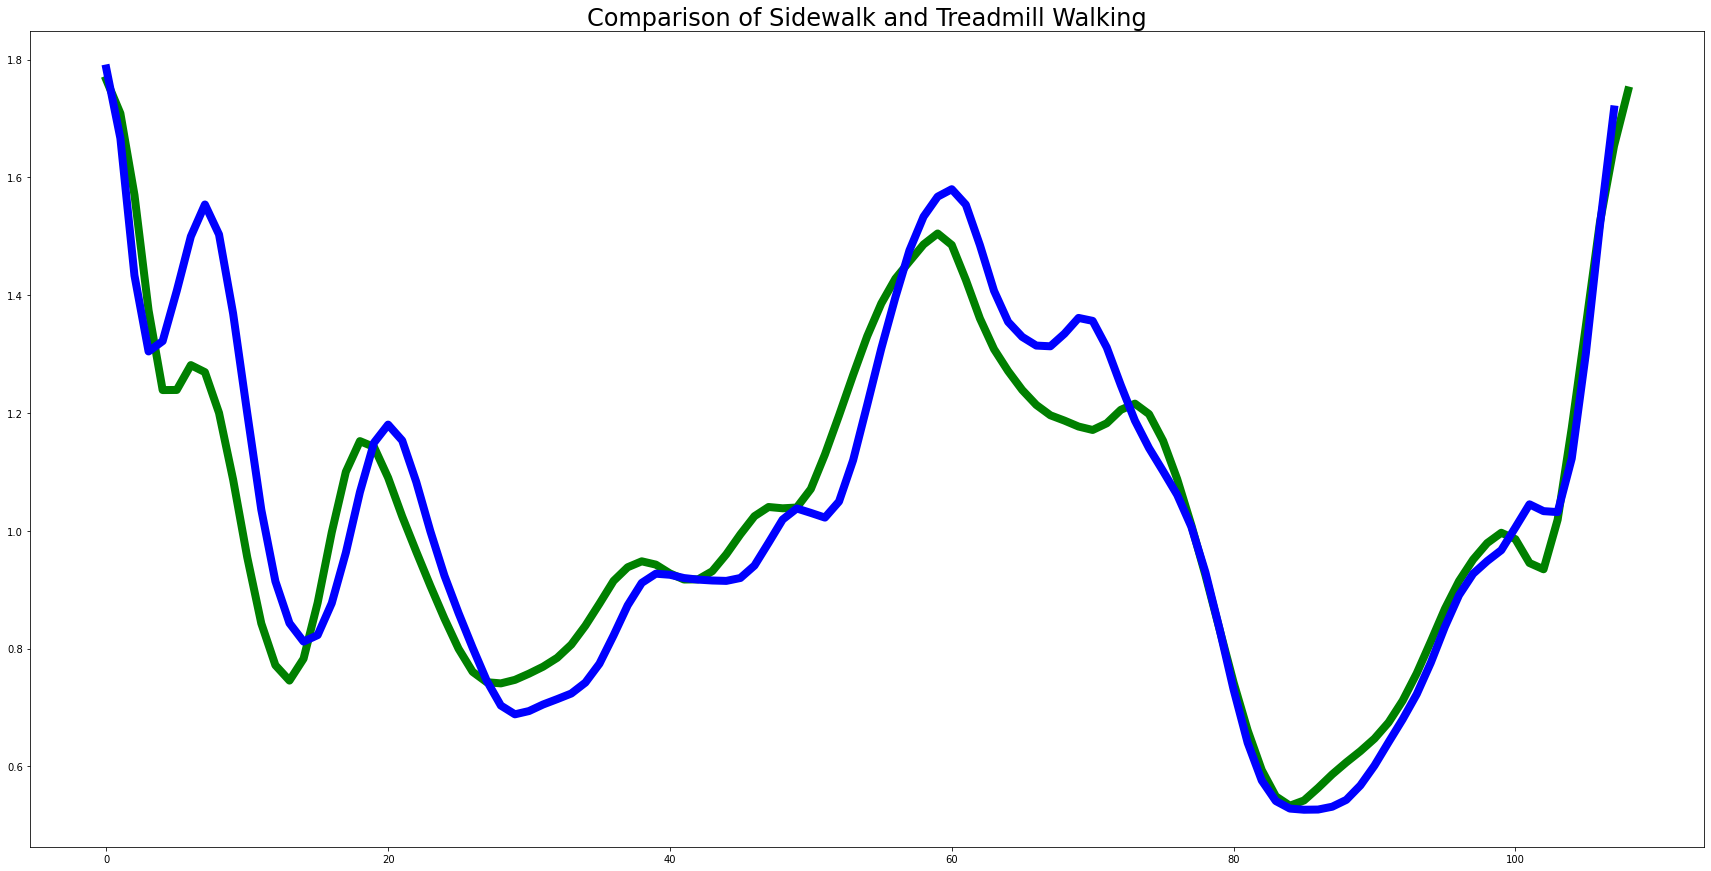

In [60]:
df = pd.read_csv('../data/labeled_activity_data/011_labeled.csv')
shape = Shapelet(df[df.activity == 'walk_sidewalk']['waist_vm'][500:2500])
shape.peak_extraction(min_dist = 80, max_dist = 150, thres = 0.7)
shape.shapelet_selection(barycenter = 'interpolated')
plt.plot(shape.shapelets[0], color = 'green', lw = 8);
shape = Shapelet(df[df.activity == 'walk_treadmill']['waist_vm'][500:2500])
shape.peak_extraction(min_dist = 80, max_dist = 150, thres = 0.7)
shape.shapelet_selection(barycenter = 'interpolated')
plt.plot(shape.shapelets[0], color = 'blue', lw = 8);
plt.title('Comparison of Sidewalk and Treadmill Walking', fontsize = 24);